In [1]:
import pandas as pd

In [2]:
import sys
sys.path.insert(0, "../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
 
data = pd.read_csv(r"../sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [4]:
train = (data["Center"] == "Leipzig") & (data["Set"] == "Training")
test = (data["Center"] == "Leipzig") & (data["Set"] == "Validation")
val = (data["Center"] == "Greifswald") & (data["Set"] == "Validation")

In [5]:
train = torch.from_numpy(train.values)
test = torch.from_numpy(test.values)
val = torch.from_numpy(val.values)

In [6]:
import torch
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES, LABEL_COLUMN_NAME

data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

X = data[FEATURES].values
y = data[LABEL_COLUMN_NAME].values

In [7]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution="normal")
scaler.fit(X[train])
X = scaler.transform(X)

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
id_grouped_data = data.groupby("Id")

In [10]:
# train_idc = torch.where(train)[0]
# new_train_idc = train_idc[:round(train_idc.shape[0]*.8)]
# new_val_idc = train_idc[round(train_idc.shape[0]*.8):]
# new_train = torch.zeros_like(train)
# new_val = torch.zeros_like(train)
# new_train[new_train_idc] = 1
# new_val[new_val_idc] = 1
# new_train = new_train.type(torch.bool)
# new_val = new_val.type(torch.bool)

In [12]:
from tqdm.notebook import tqdm

X_train_sequences = dict({})
y_train_sequences = dict({})

X_test_sequences = dict({})
y_test_sequences = dict({})

X_test_gw_sequences = dict({})
y_test_gw_sequences = dict({})

for id, data in tqdm(id_grouped_data):
    time_series_len = data.shape[0]
    is_training = (data["Set"] == "Training").all()
    is_gw_test = (data["Center"] == "Greifswald").all()
    X_sgd = torch.from_numpy(data[FEATURES].values).type(torch.float).unsqueeze(0)
    y_sgd = torch.from_numpy(data[LABEL_COLUMN_NAME].values).type(torch.float)
    if is_training:
        if time_series_len not in X_train_sequences:
            X_train_sequences[time_series_len] = []
            y_train_sequences[time_series_len] = []
        X_train_sequences[time_series_len].append(X_sgd)
        y_train_sequences[time_series_len].append(y_sgd)
    elif is_gw_test:
        if time_series_len not in X_test_gw_sequences:
            X_test_gw_sequences[time_series_len] = []
            y_test_gw_sequences[time_series_len] = []
        X_test_gw_sequences[time_series_len].append(X_sgd)
        y_test_gw_sequences[time_series_len].append(y_sgd)
    else:
        if time_series_len not in X_test_sequences:
            X_test_sequences[time_series_len] = []
            y_test_sequences[time_series_len] = []
        X_test_sequences[time_series_len].append(X_sgd)
        y_test_sequences[time_series_len].append(y_sgd)
    assert data["Set"].unique().shape[0] == 1
    assert data["Center"].unique().shape[0] == 1

  0%|          | 0/866517 [00:00<?, ?it/s]

In [13]:
import numpy as np

def get_batches(X_sequences:dict, y_sequences:dict):
    X_batches = []
    y_batches = []
    for key in tqdm(X_sequences.keys()):
        X_batch = torch.from_numpy(np.array(X_sequences[key]).squeeze(axis=1))
        y_batch = torch.from_numpy(np.array(y_sequences[key]))
    
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    return (X_batches, y_batches)

In [14]:
X_train_batches, y_train_batches = get_batches(X_train_sequences, y_train_sequences)
X_test_batches, y_test_batches = get_batches(X_test_sequences, y_test_sequences)
X_test_gw_batches, y_test_gw_batches = get_batches(X_test_gw_sequences, y_test_gw_sequences)

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [15]:
for batch in y_batches:
    print(batch.shape)

NameError: name 'y_batches' is not defined

In [16]:
sets = dict()
sets["train"] = X_train_batches
# sets["val"] = X_times[new_val]
sets["test"] =  X_test_batches
sets["gw_test"] =  X_test_gw_batches

In [17]:
labels = dict()
labels["train"] = y_train_batches
# labels["val"] = y[new_val]
labels["test"] =  y_test_batches
labels["gw_test"] = y_test_gw_batches

In [18]:
losses = dict()
losses["train"] = []
losses["val"] = []
losses["test"] = []
losses["gw_test"] = []

In [19]:
aurocs = dict()
aurocs["train"] = []
aurocs["val"] = []
aurocs["test"] = []
aurocs["gw_test"] = []

In [20]:
counts = torch.unique(y[train], return_counts=True)[-1]
WEIGHT = counts[0] / counts[-1]
WEIGHT

tensor(664.1861)

In [21]:
from sklearn.metrics import roc_auc_score

def evaluate(model, set_name):
    global X_times, losses, labels
    with torch.inference_mode():
        model.eval()
        acc_loss = 0
        batch_size = 0
        acc_labels = []
        acc_proba = []
        
        for idx, x in enumerate(sets[set_name]):
            logits = model(x)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.squeeze(-1), labels[set_name][idx],pos_weight=WEIGHT)
            last_proba_set = torch.sigmoid(logits.squeeze(-1))
        
            acc_labels.extend(labels[set_name][idx].view(-1).cpu().tolist())
            acc_proba.extend(last_proba_set.view(-1).cpu().tolist())
            acc_loss += loss.item()
            batch_size+= x.shape[0]
        losses[set_name].append(acc_loss/batch_size)
        auroc = roc_auc_score(np.array(acc_labels), np.array(acc_proba))
        aurocs[set_name].append(auroc)
        # print(f"{set_name} has AUROC: {auroc}")

In [61]:
def full_batch_epoch(model):
    global X_times, y, sets
    model.train()
    optim.zero_grad()
    acc_loss = 0
    
    for idx, x in enumerate(sets["train"]):
        logits = model(x)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.squeeze(-1), labels["train"][idx],pos_weight=WEIGHT)
        acc_loss+= loss.item()
        loss.backward()
    
    print(acc_loss)
    for set_name in sets:
        evaluate(model, set_name)
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=2)
    optim.step()
    ## added grad clip here
    
    return acc_loss

In [62]:
from torch import nn
from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, layers, is_bidirectional = False):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden_size #hidden state
        self.num_layers = layers
        self.hidden_scale = 2 if is_bidirectional else 1
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True, bidirectional=is_bidirectional) #lstm
        self.fc_1 =  nn.Linear(self.hidden_size*self.hidden_scale, 1) #fully connected 1

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*self.hidden_scale, x.shape[0], self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers*self.hidden_scale, x.shape[0], self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, _) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(output[:,:, :])
        out = self.fc_1(out) #first Dense
        return out#output[:,-1,0] #out

In [63]:
def empty_dict(dictionary):
    for key in dictionary.keys():
        dictionary[key] = []

In [64]:
def transfer_dict(dictionary,device):
    for key in dictionary.keys():
        for idx in range(len(dictionary[key])):
            dictionary[key][idx] =  dictionary[key][idx].to(device)

In [65]:
device = torch.device("cuda:2")

In [66]:
from tqdm.notebook import tqdm
import time

is_continue = False
if not is_continue:
    model = LSTM1(1, X.shape[1],256, 3, False).to(device) ##reduce in biLSTM number of neurons ##continously uncrease time window ##dropout ##vary batch size/use batchnorm
    ## weight decay
    transfer_dict(sets, device)
    transfer_dict(labels, device)
    empty_dict(losses)
    empty_dict(aurocs)
    lr = 0.001
    optim = torch.optim.Adam(params=model.parameters(), lr = lr)

# patience = 30
epochs = 110

for epoch in tqdm(range(epochs)):
    print(epoch)
    start = time.time()
    loss = full_batch_epoch(model)
    # if len(losses["val"]) > patience and all(list(map(lambda l: l<=losses["val"][-1], losses["val"][-patience-1:]))):
    #     break
    print(loss)

  0%|          | 0/110 [00:00<?, ?it/s]

0
194.40636283159256
194.40636283159256
1
193.7377980351448
193.7377980351448
2
193.11829698085785
193.11829698085785
3
192.52874886989594
192.52874886989594
4
191.9650644659996
191.9650644659996
5
191.41567343473434
191.41567343473434
6
190.86743092536926
190.86743092536926
7
190.32167011499405
190.32167011499405
8
189.78112250566483
189.78112250566483
9
189.24096685647964
189.24096685647964
10
188.70023691654205
188.70023691654205
11
188.15138626098633
188.15138626098633
12
187.5968592762947
187.5968592762947
13
187.05215847492218
187.05215847492218
14
186.51843190193176
186.51843190193176
15
185.99379539489746
185.99379539489746
16
185.49023872613907
185.49023872613907
17
185.0159611105919
185.0159611105919
18
184.57303988933563
184.57303988933563
19
184.15745615959167
184.15745615959167
20
183.76422137022018
183.76422137022018
21
183.38349705934525
183.38349705934525
22
182.99674344062805
182.99674344062805
23
182.58637446165085
182.58637446165085
24
182.14013707637787
182.14013707

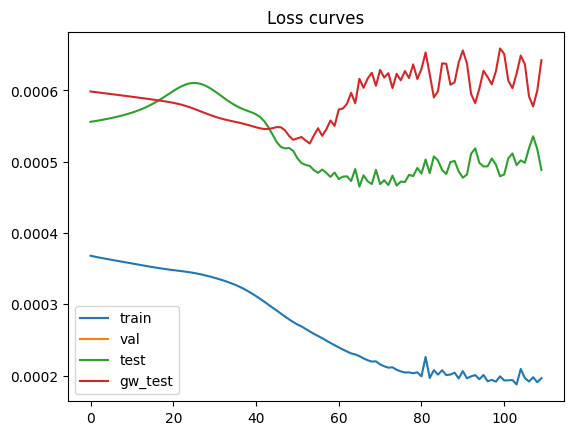

In [67]:
import matplotlib.pyplot as plt

for set_name in losses:
    plt.plot(losses[set_name])
plt.legend(losses.keys())
plt.title("Loss curves")
plt.show()

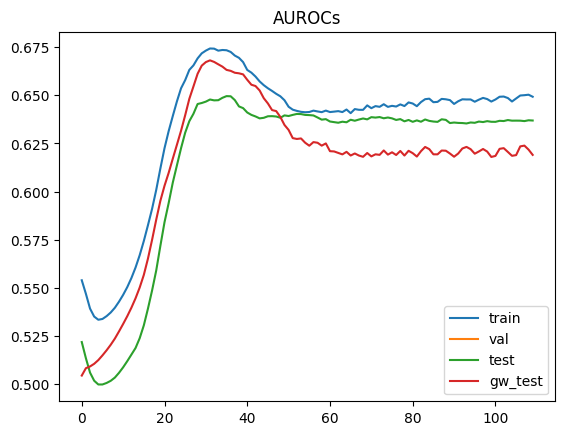

In [68]:
import matplotlib.pyplot as plt

for set_name in aurocs:
    plt.plot(aurocs[set_name])
plt.legend(aurocs.keys())
plt.title("AUROCs")
plt.show()

In [69]:
max(aurocs["test"]), aurocs["gw_test"][-1]

(0.6495778347643645, 0.6190600779590542)

## Evaluate the time series equence lengths

In [307]:
id_grouped_data.size().describe()

count    866517.000000
mean          2.099711
std           3.201005
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         416.000000
dtype: float64

In [312]:
num_sampples_list =  []
for i in range(id_grouped_data.size().max()+1):
    num_samples = (id_grouped_data.size() == i).sum()
    num_sampples_list.append(num_samples)

Text(0.5, 0, 'Length of time series')

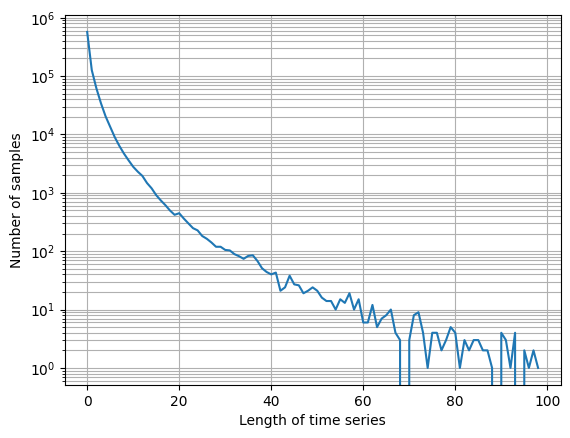

In [322]:
import matplotlib.pyplot as plt
plt.semilogy(num_sampples_list[1:100])
plt.grid(which="both")
plt.ylabel("Number of samples")
plt.xlabel("Length of time series")